In [3]:
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import math
import shutil

In [4]:
gifs = os.listdir('gifs')

for i, gif in enumerate(gifs):
    shutil.copyfile('gifs/' + gif, 'Gifs/' + str(i) + '.gif')

In [ ]:
img = Image.open("gifs/4.gif")

arr = np.array(img)

blue_c = arr[259:279, 32:52, :]
Image.fromarray(blue_c).save("pink.png")

plt.imshow(arr[259:279, 32:52, :])

In [5]:
def getCoords(img, template, find_num, show=False):
    List = []
    w, h = template.shape[0], template.shape[1]

    showImg = img.copy()

    result = cv2.matchTemplate(img,template, cv2.TM_CCOEFF_NORMED)
    # get find_num best matches
    loc = np.where(result >= np.sort(result.flatten())[-find_num])
    

    for i in zip(*loc[::-1]):
        location = (i[0] + w, i[1] + h)
        List.append([i, location])

        cv2.rectangle(showImg, i, location, 255, 0)

    List = sorted(List, key=lambda x: x[0][1])

    if show:
        plt.imshow(showImg)
        plt.show()
    return List

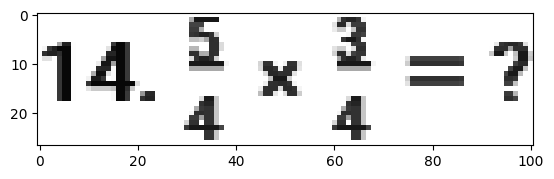

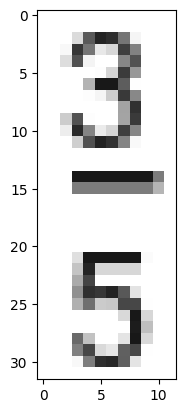

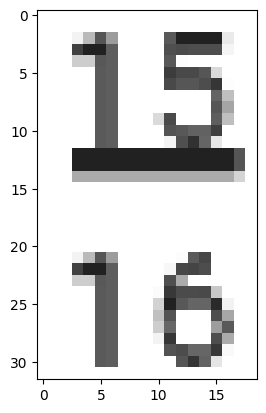

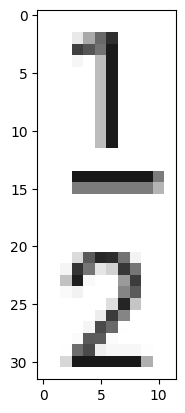

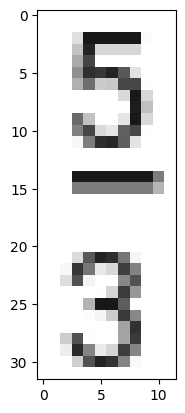

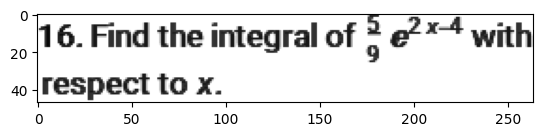

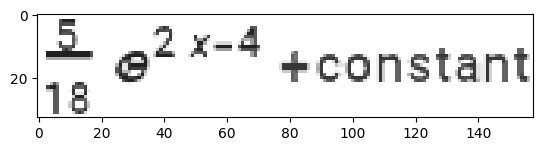

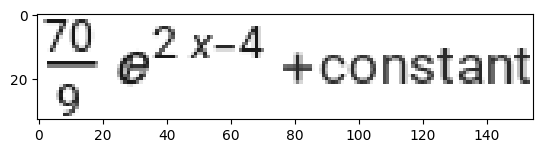

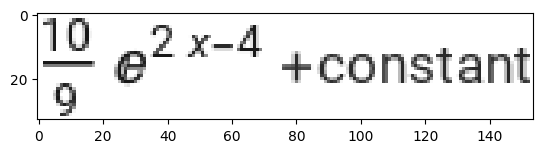

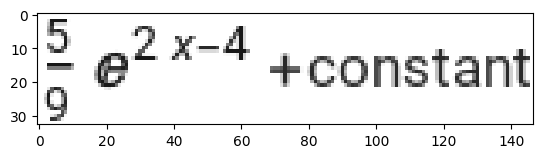

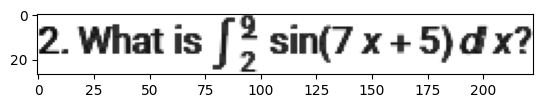

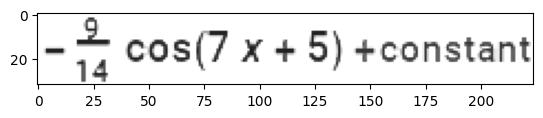

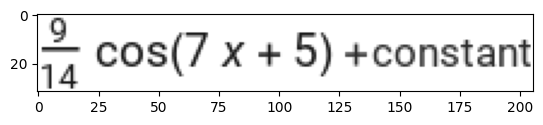

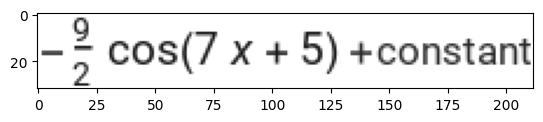

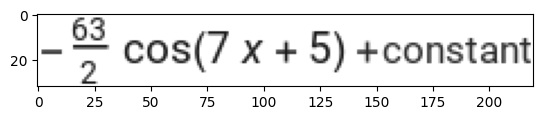

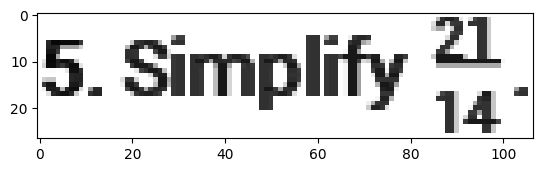

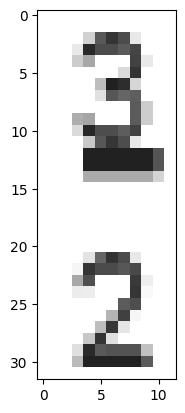

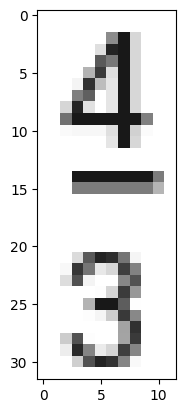

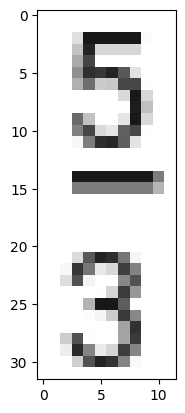

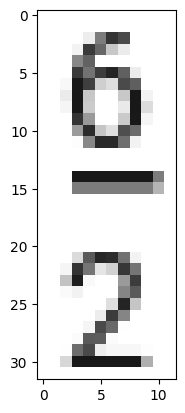

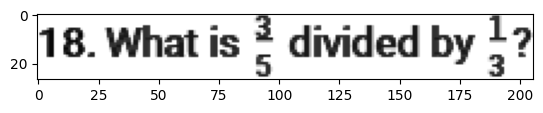

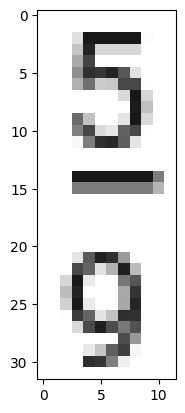

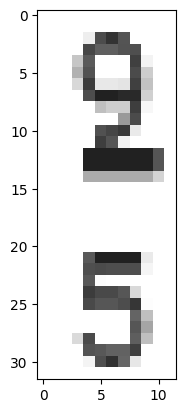

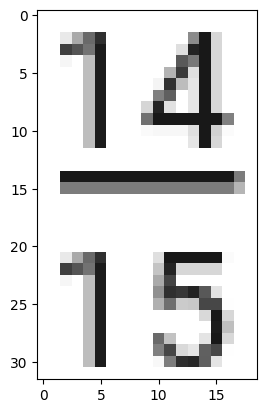

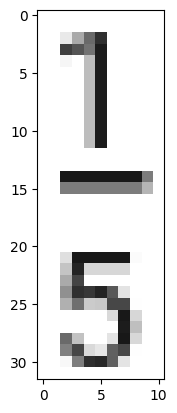

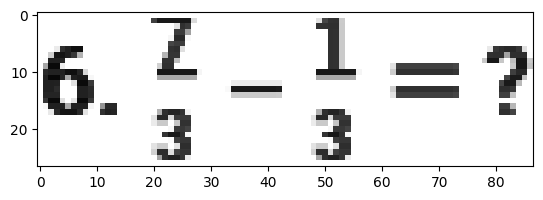

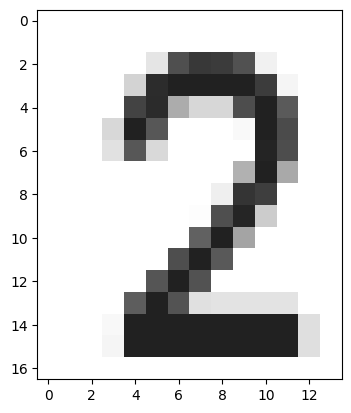

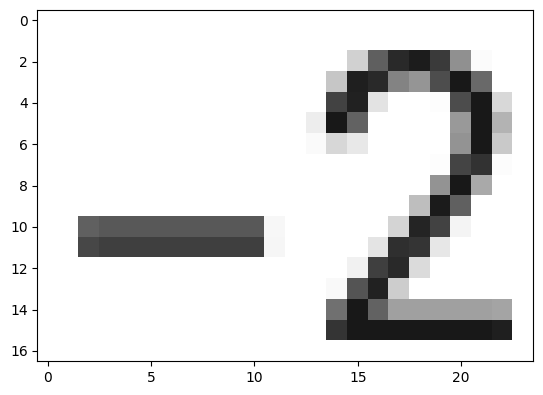

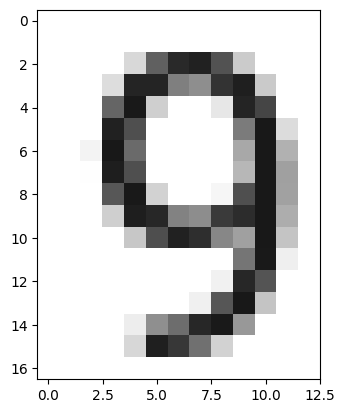

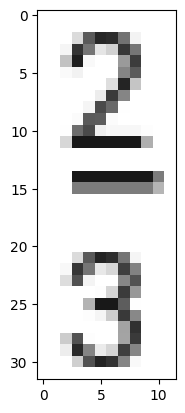

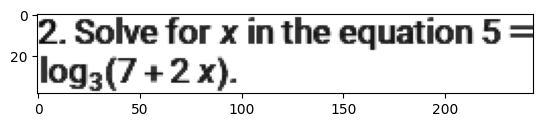

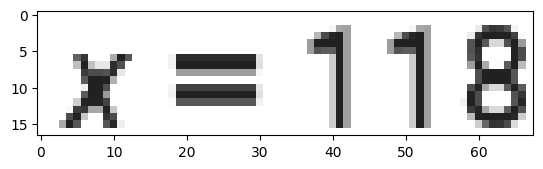

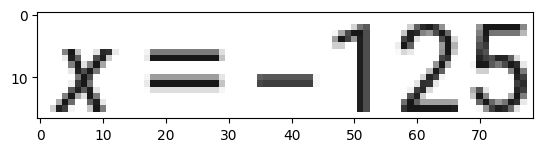

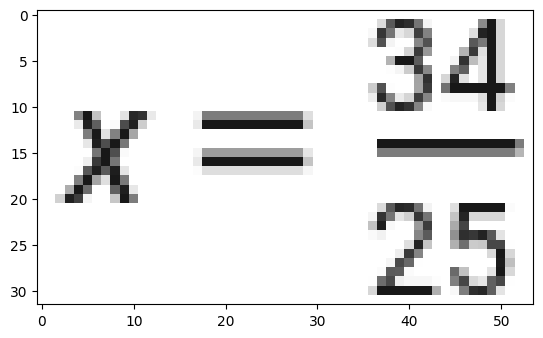

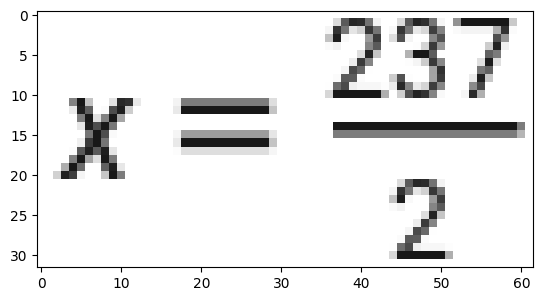

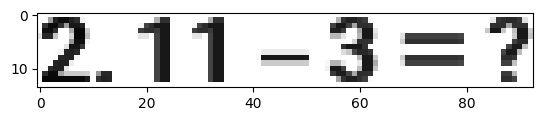

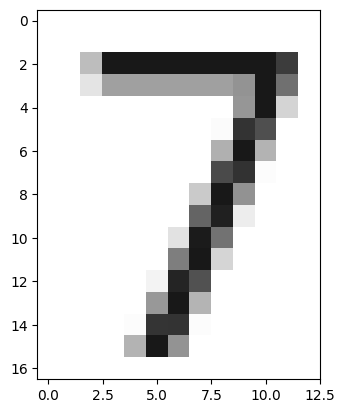

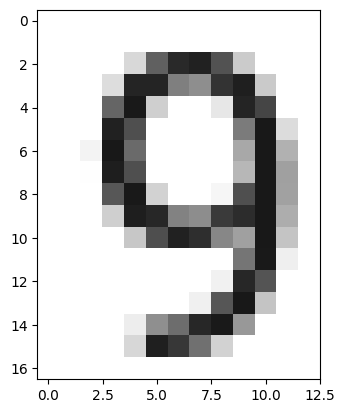

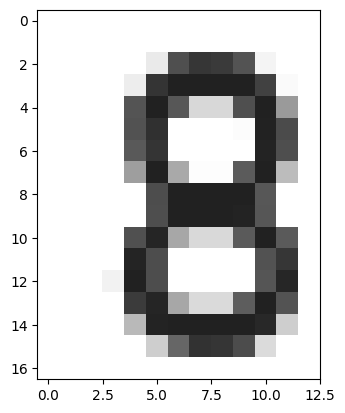

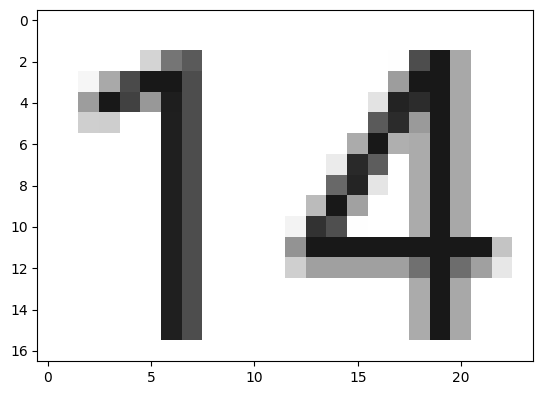

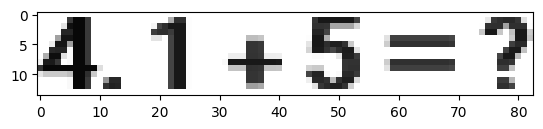

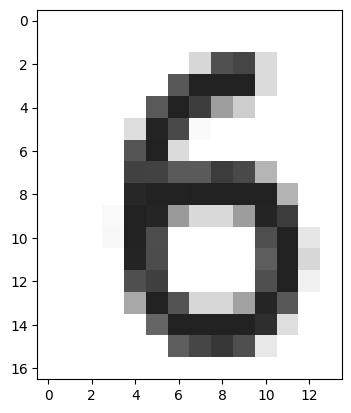

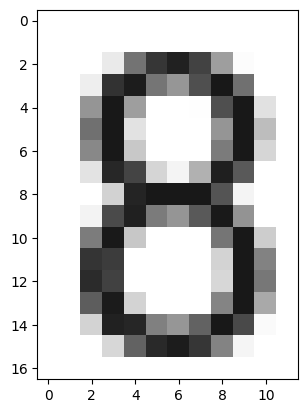

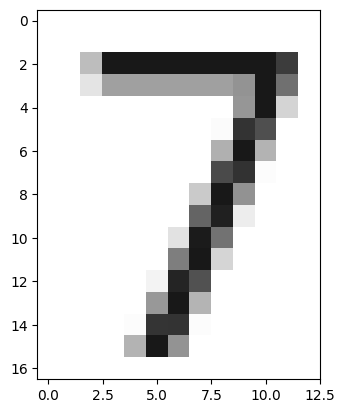

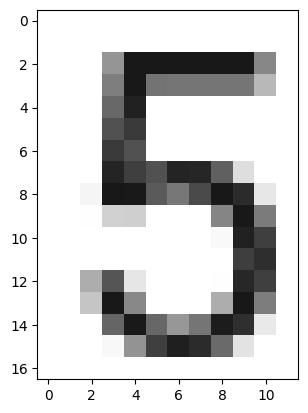

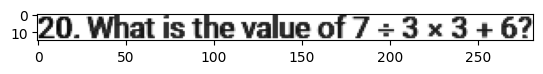

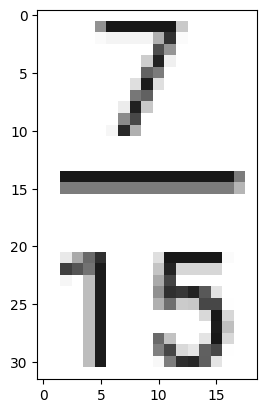

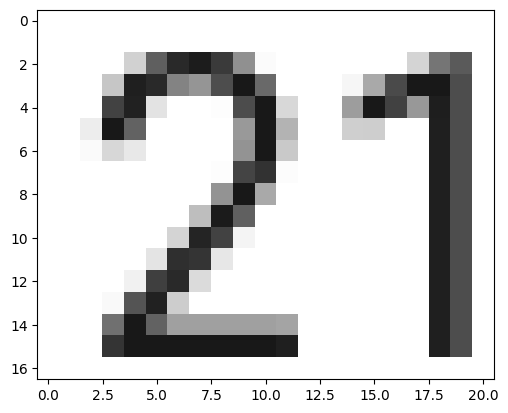

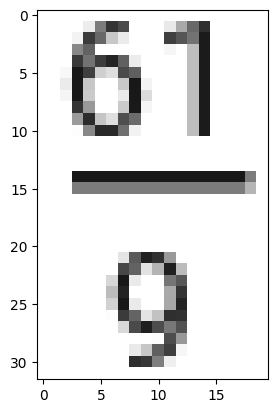

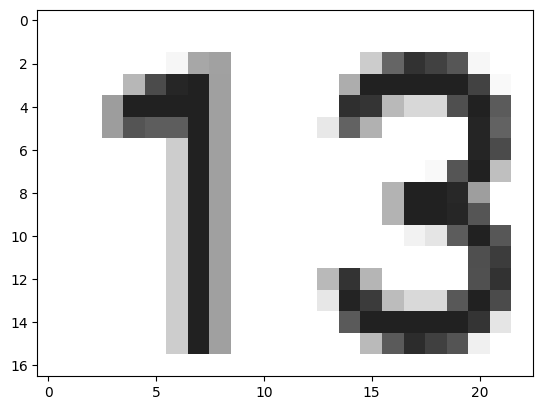

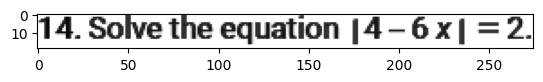

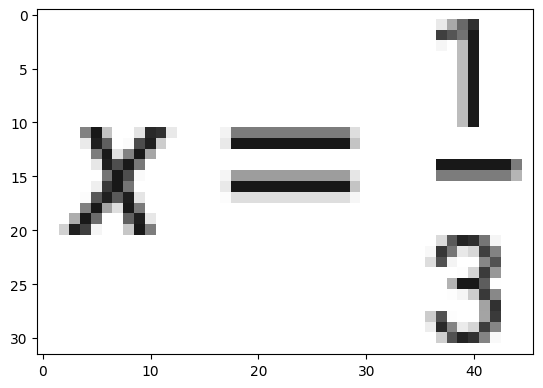

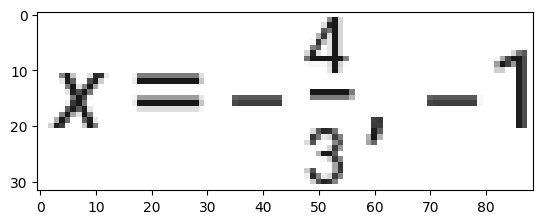

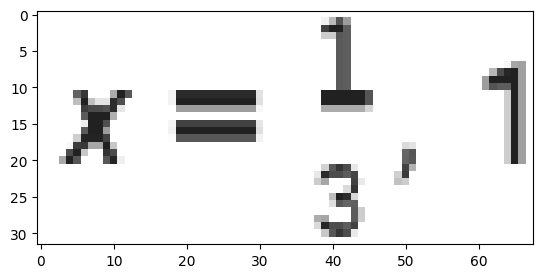

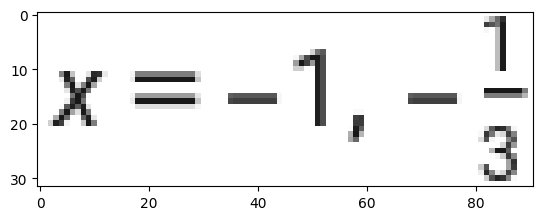

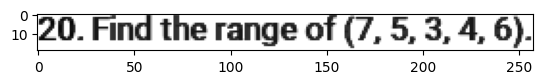

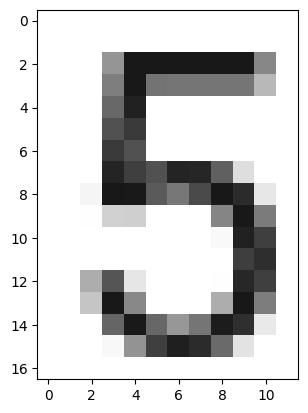

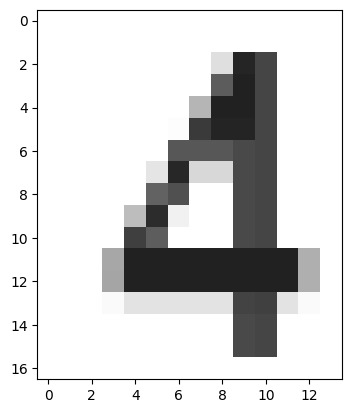

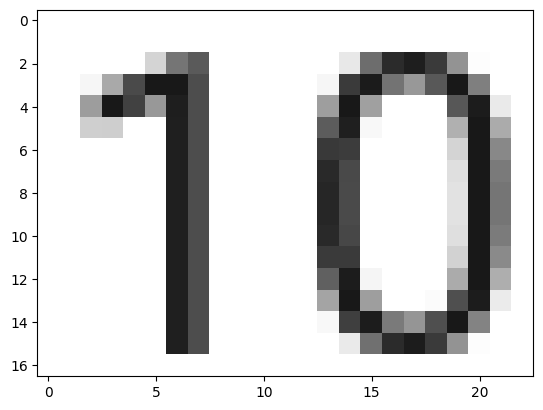

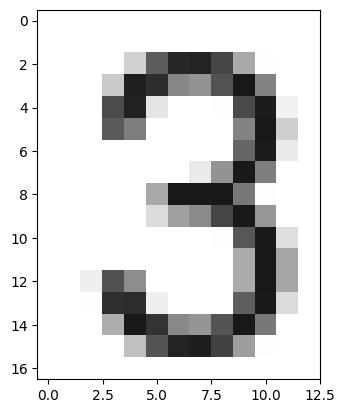

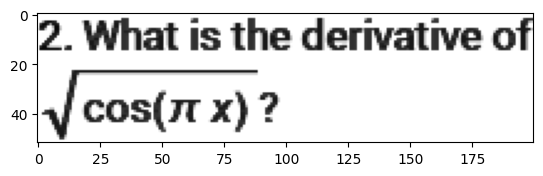

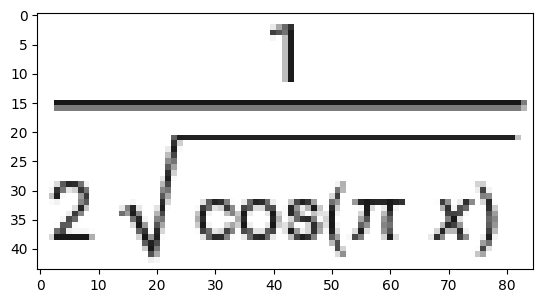

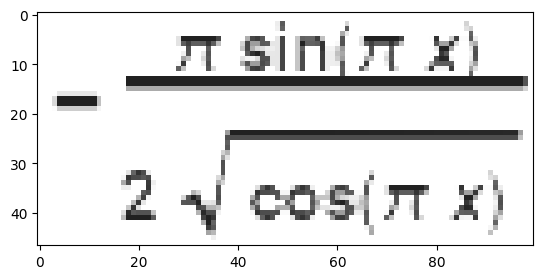

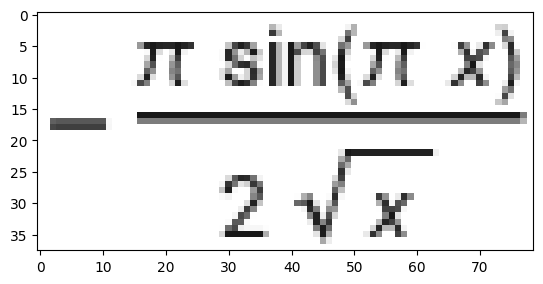

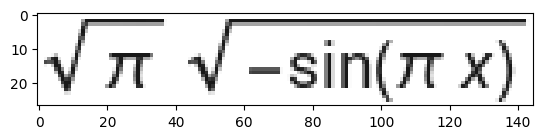

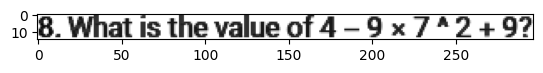

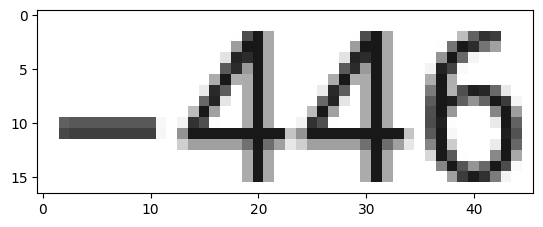

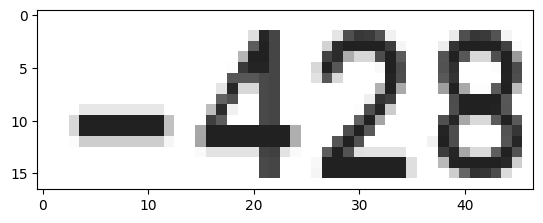

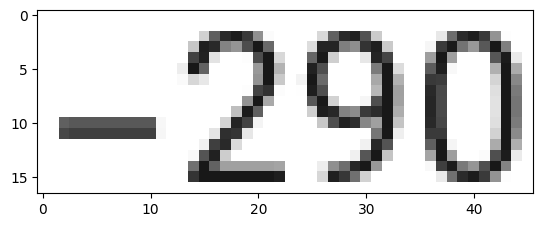

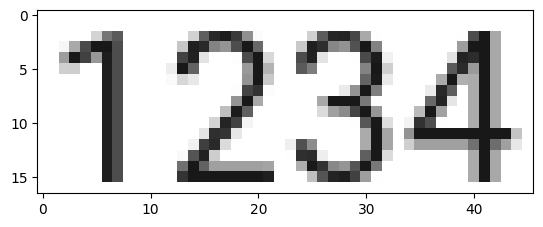

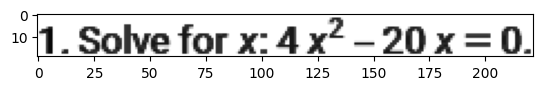

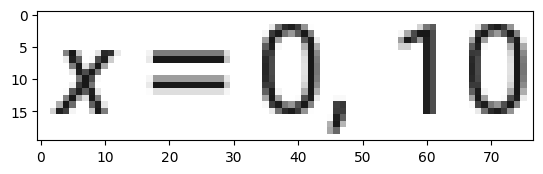

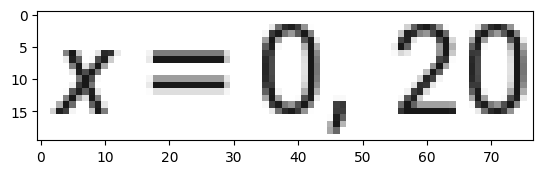

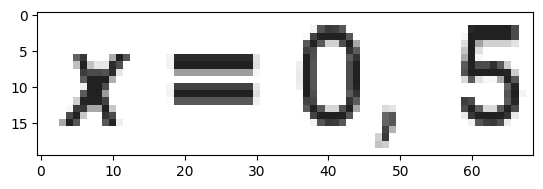

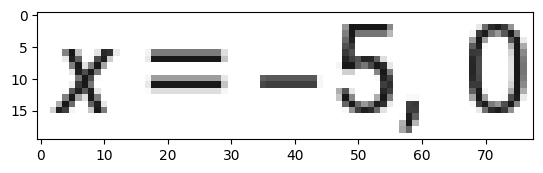

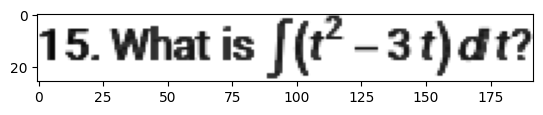

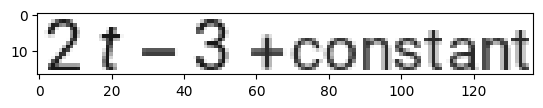

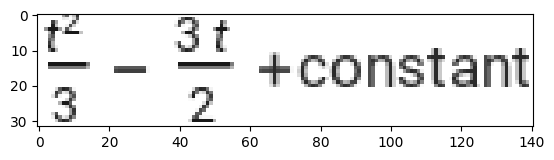

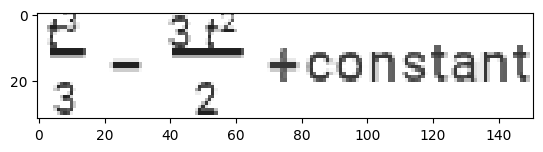

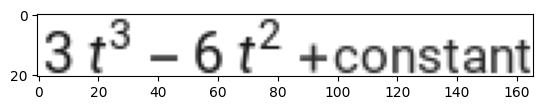

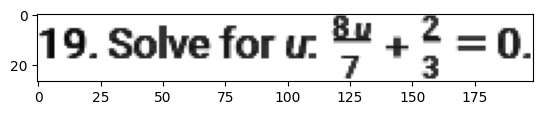

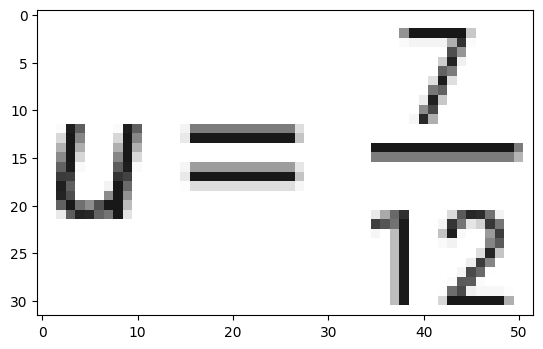

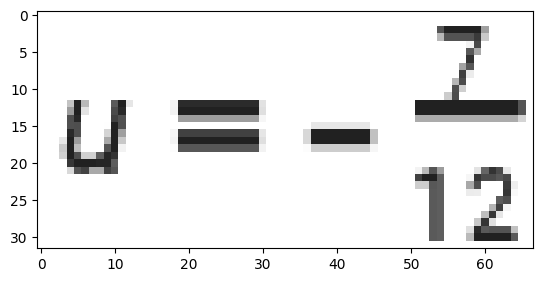

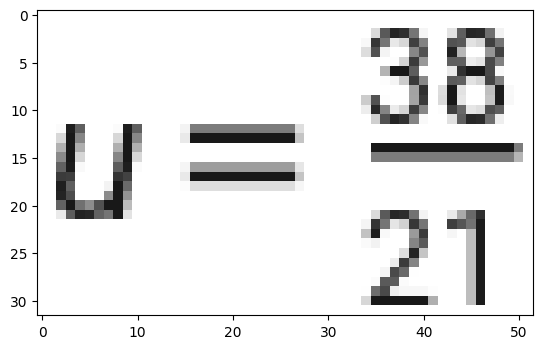

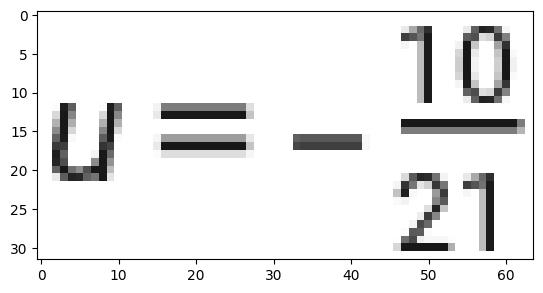

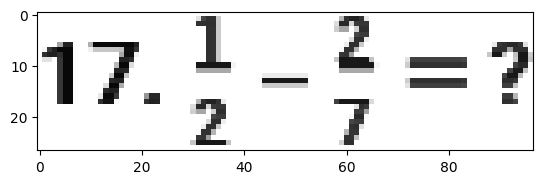

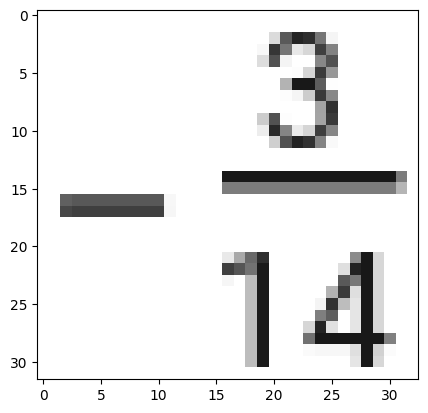

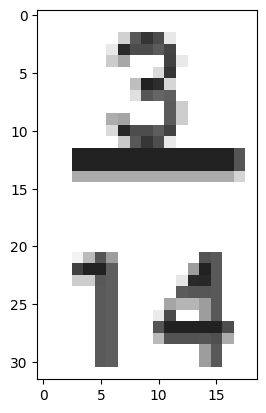

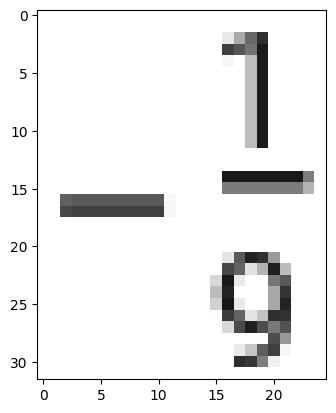

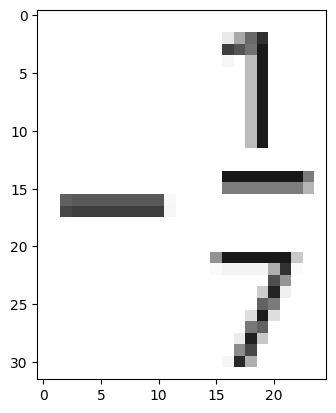

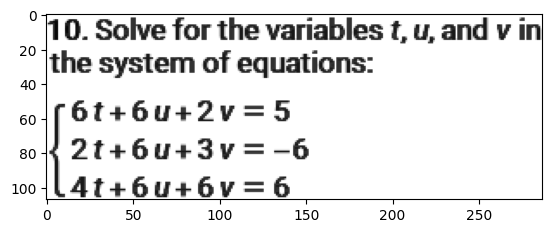

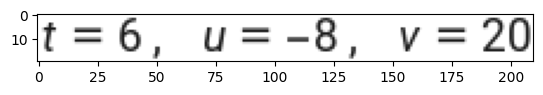

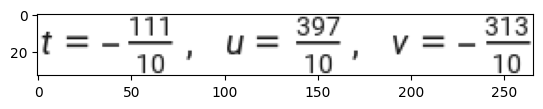

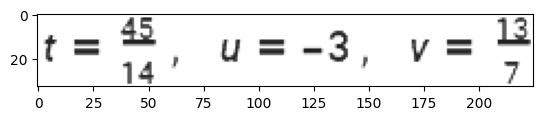

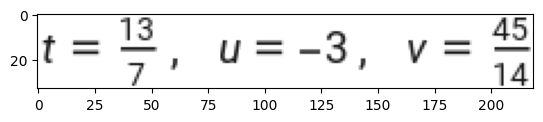

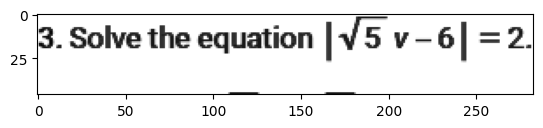

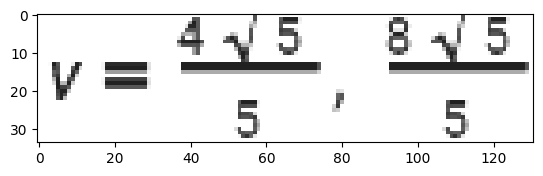

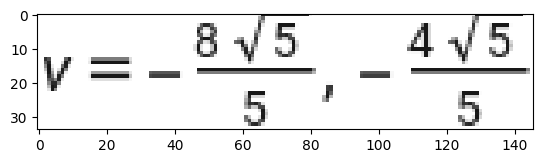

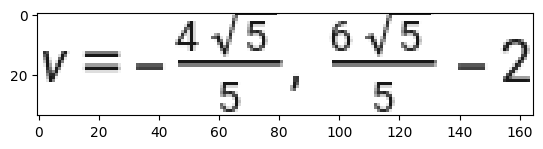

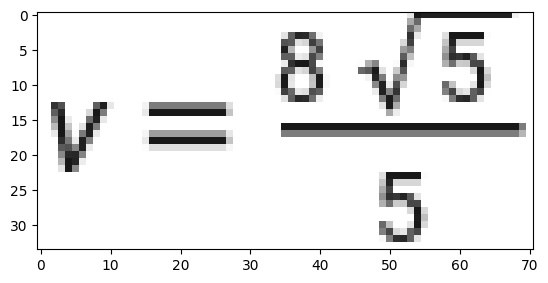

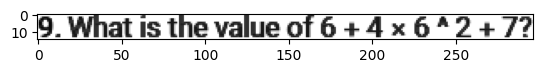

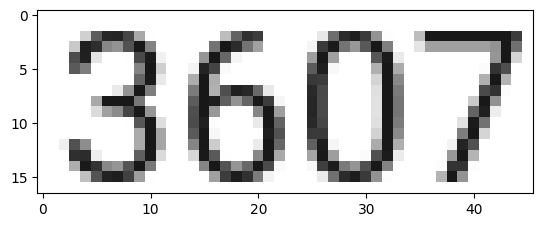

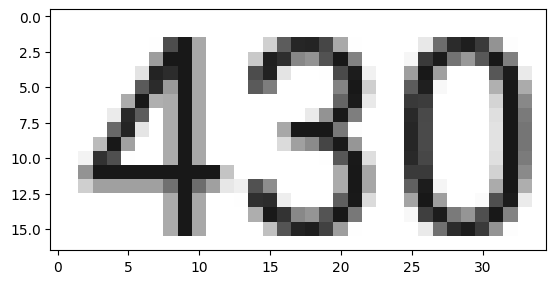

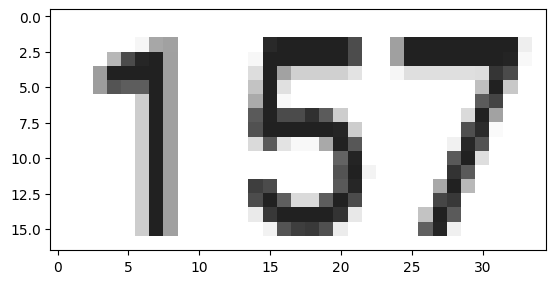

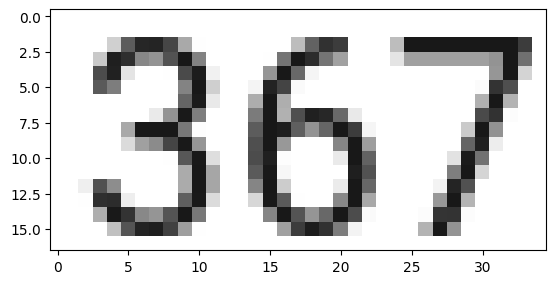

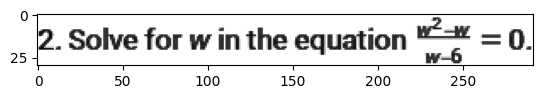

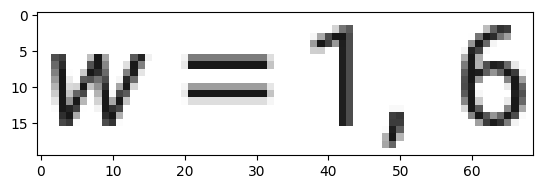

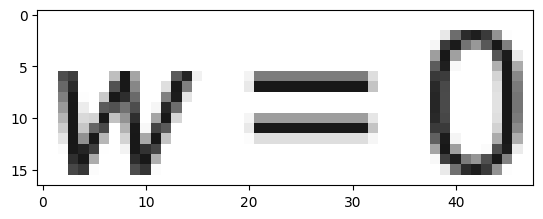

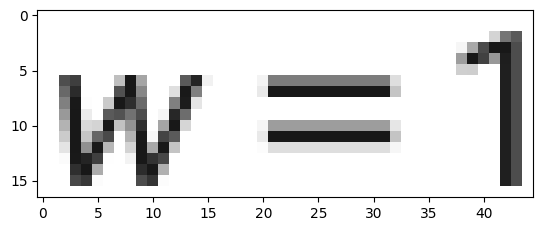

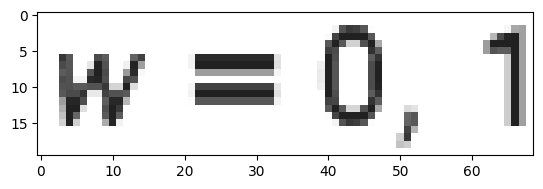

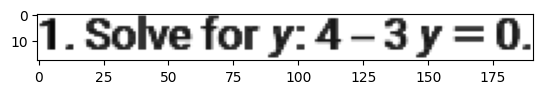

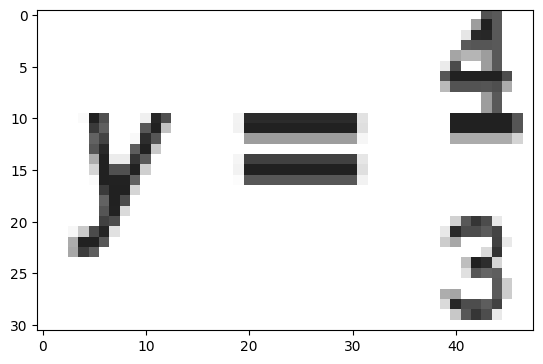

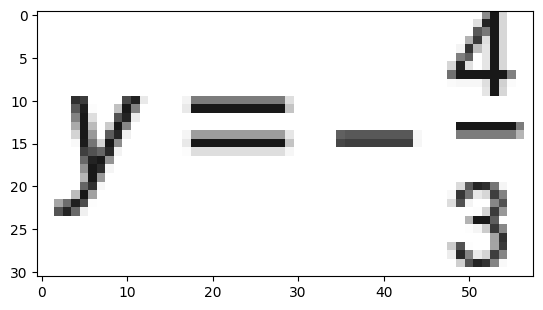

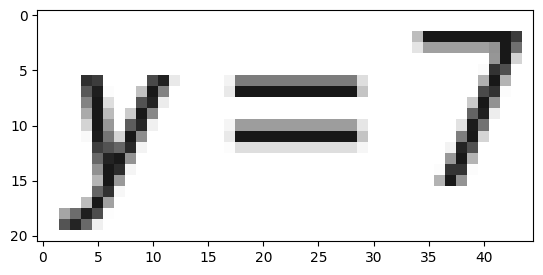

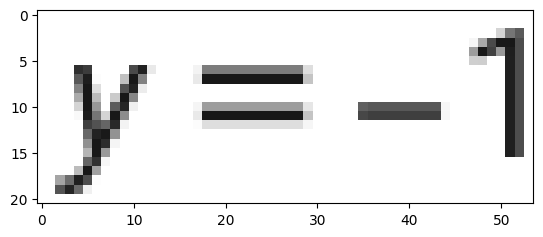

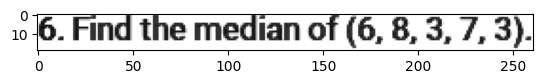

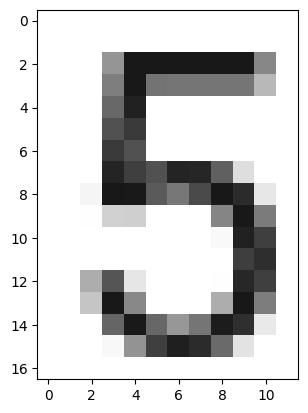

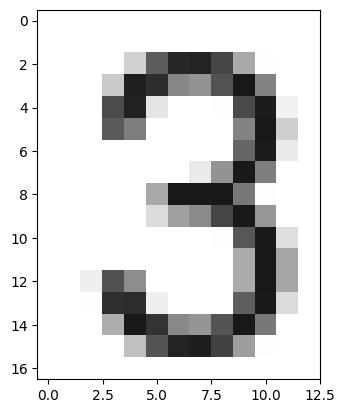

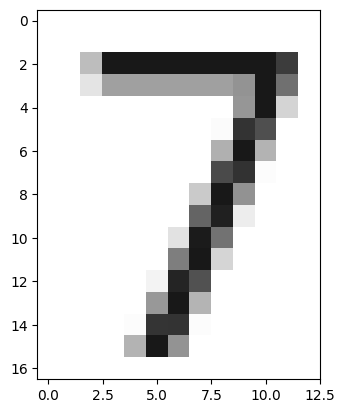

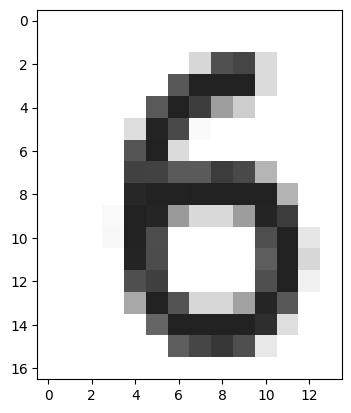

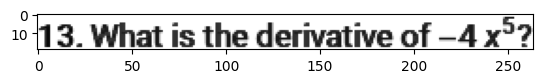

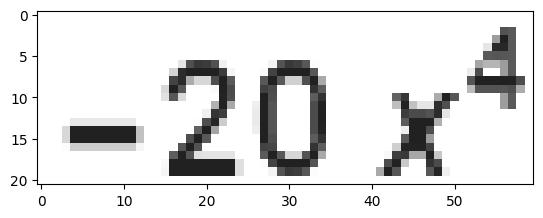

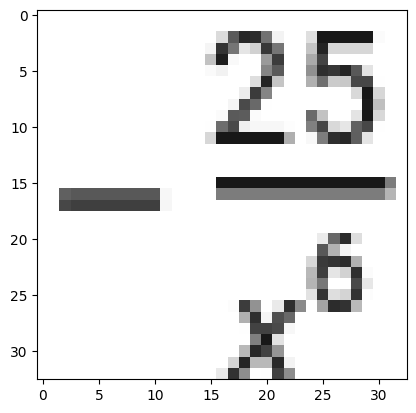

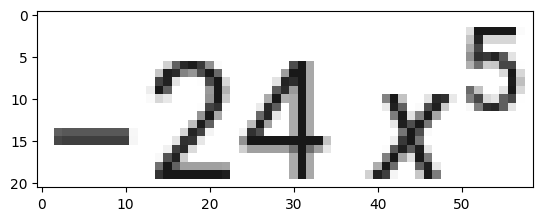

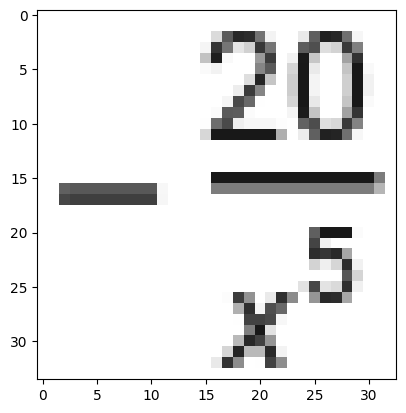

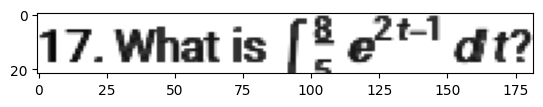

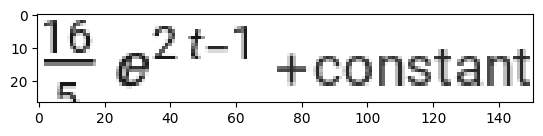

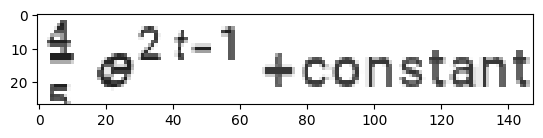

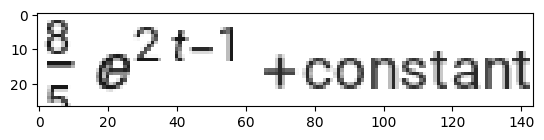

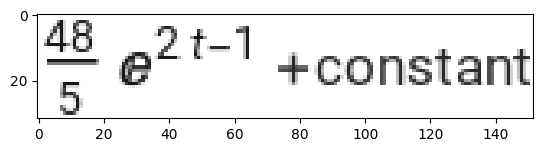

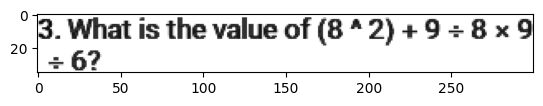

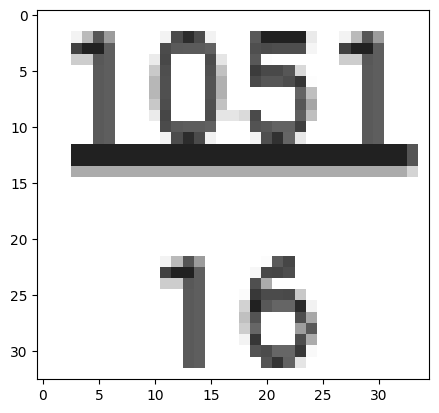

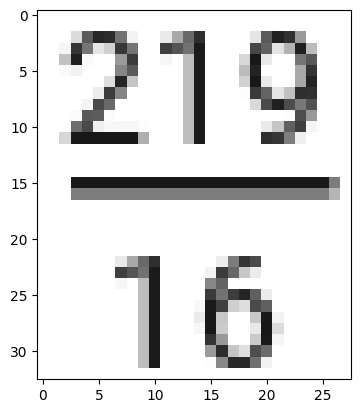

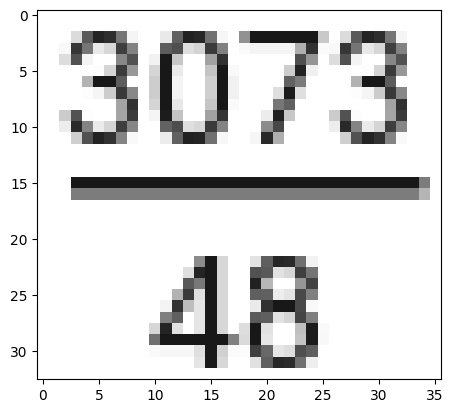

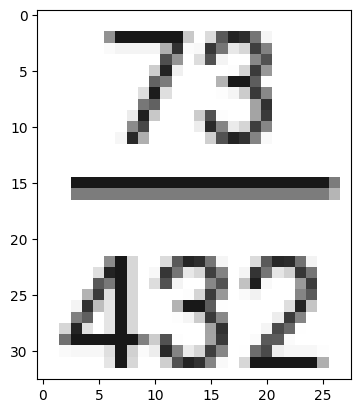

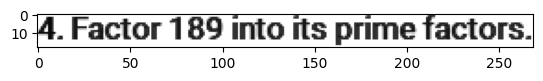

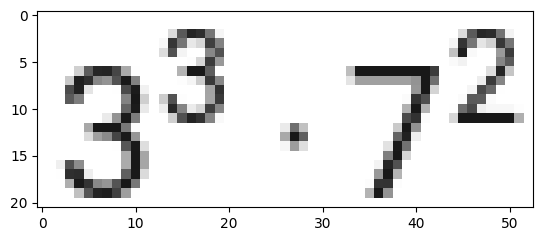

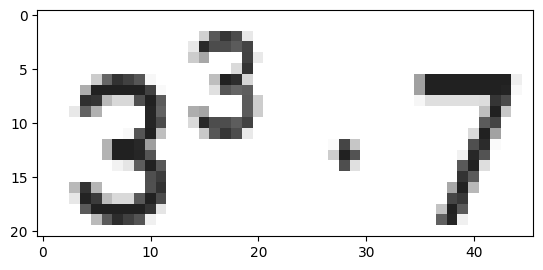

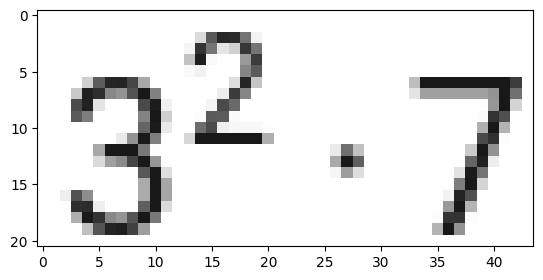

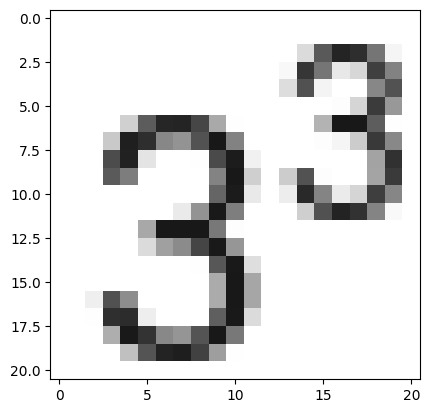

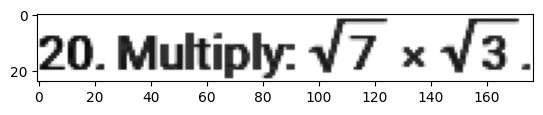

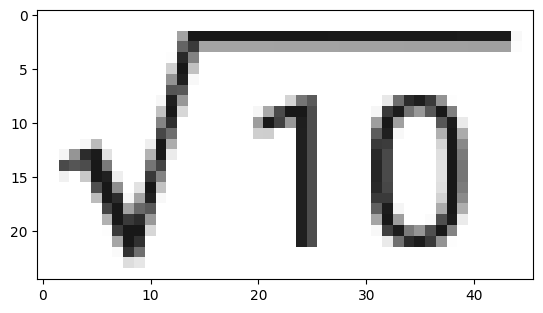

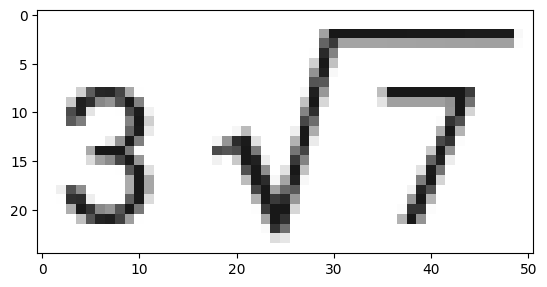

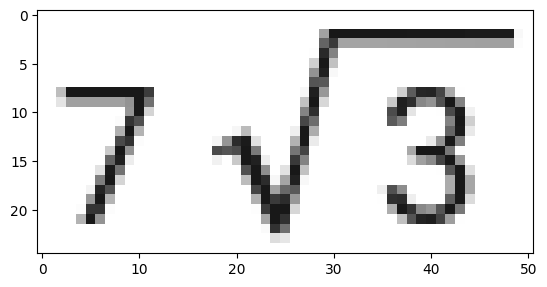

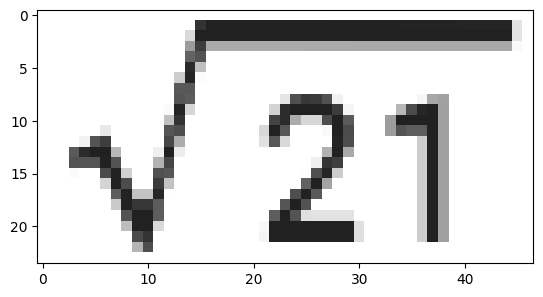

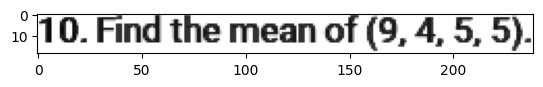

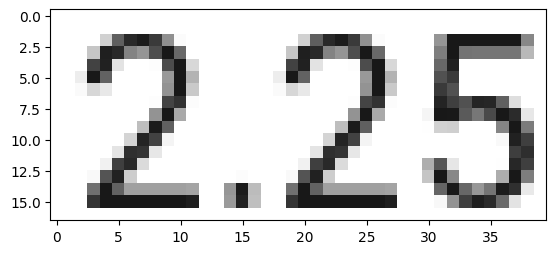

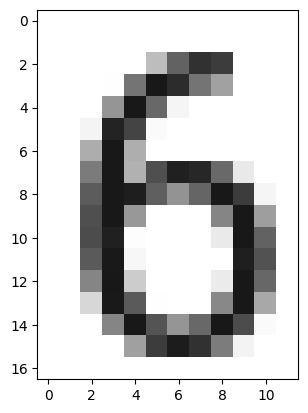

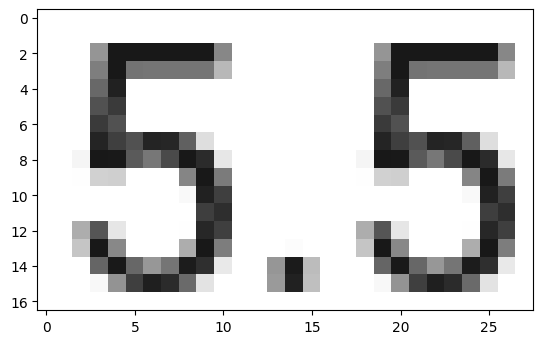

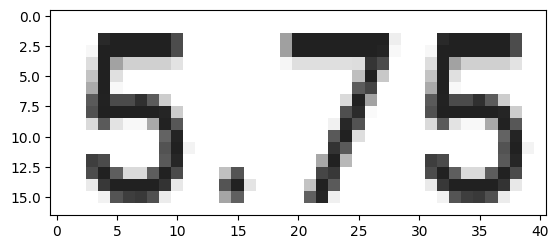

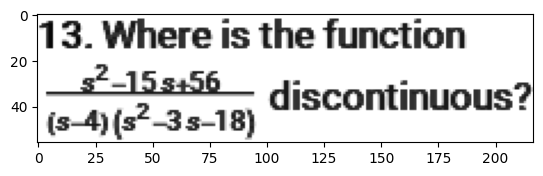

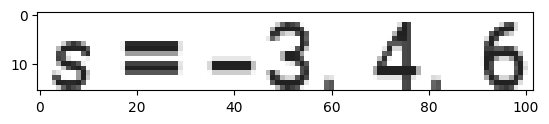

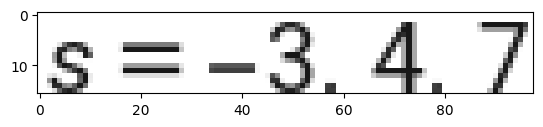

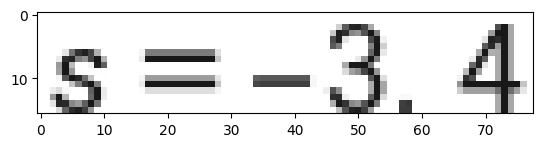

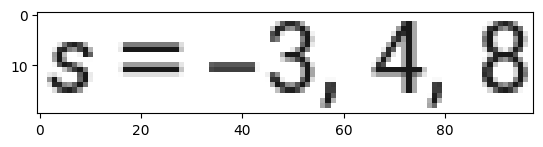

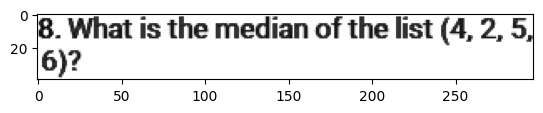

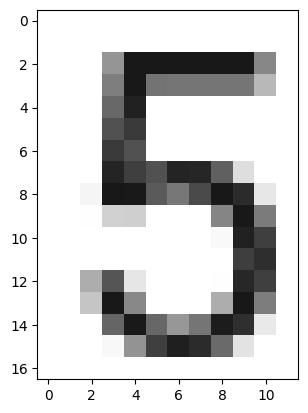

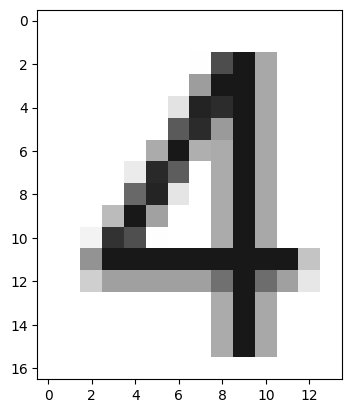

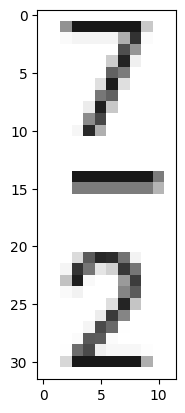

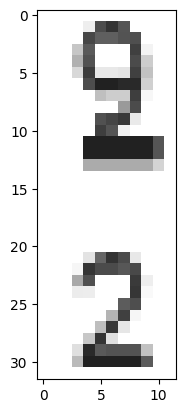

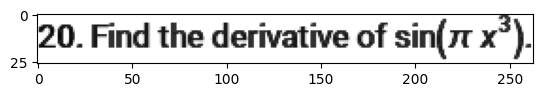

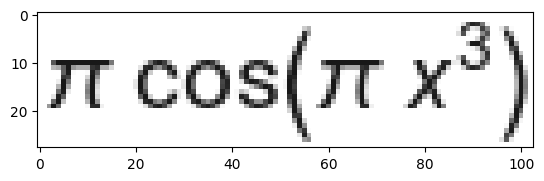

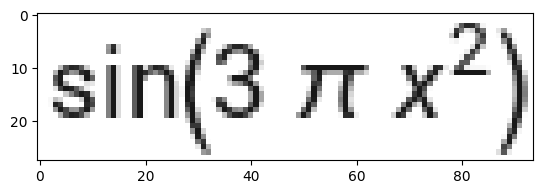

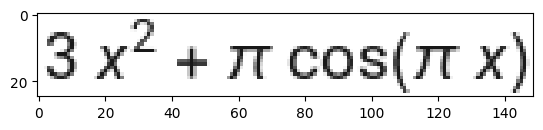

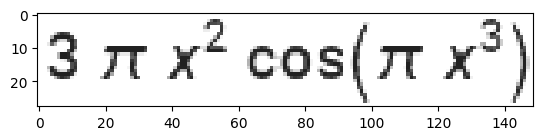

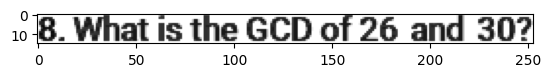

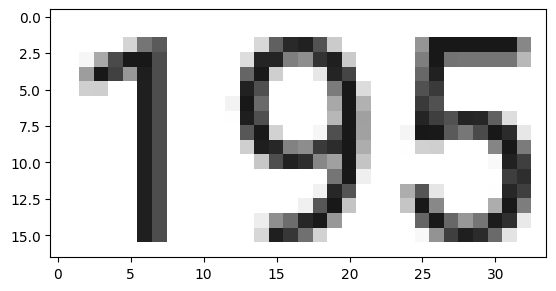

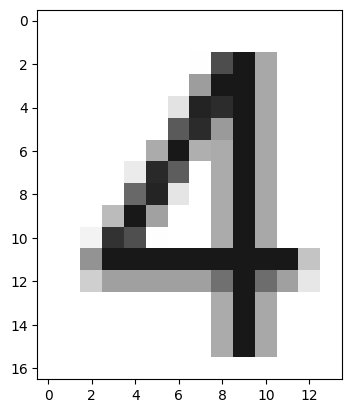

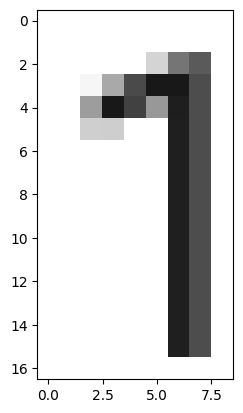

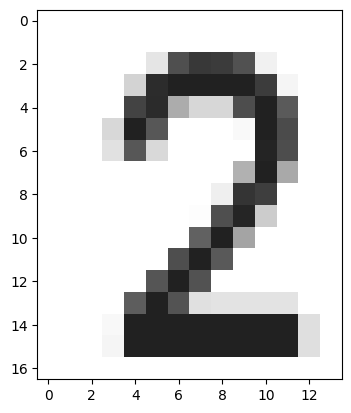

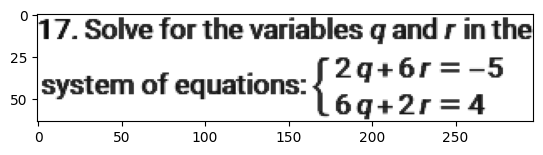

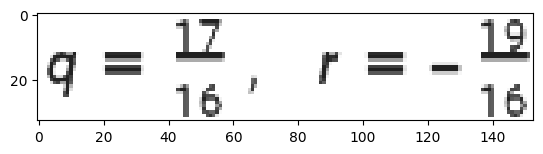

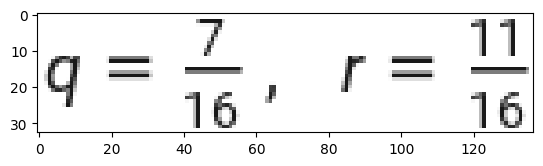

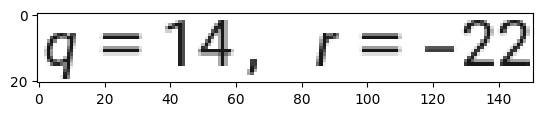

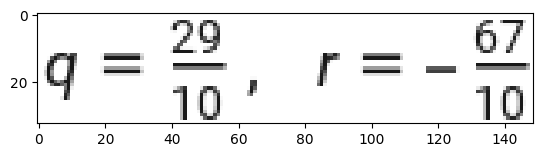

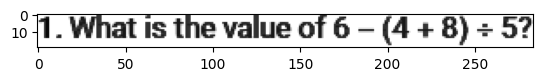

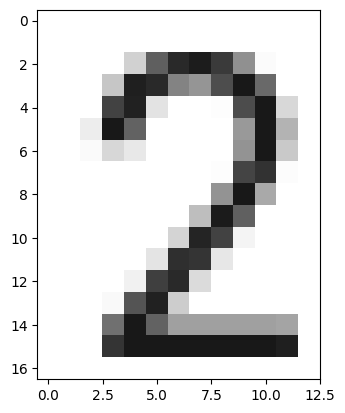

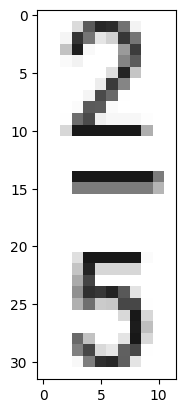

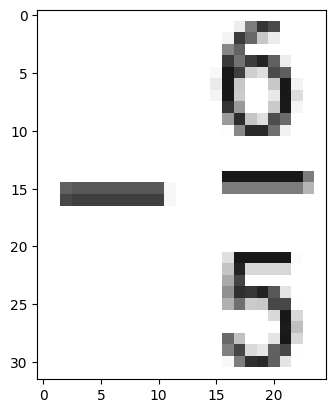

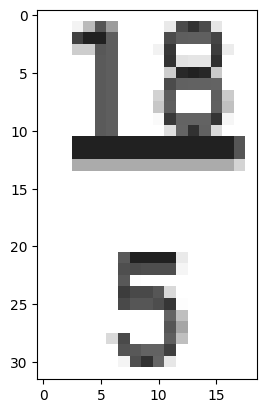

In [9]:
gifs = os.listdir("gifs")

os.system("rm -rf processedImgs")
os.mkdir("processedImgs")

for gif in gifs:
    img = cv2.imread(f'gifs/{gif}',-1)
    blue_template = cv2.imread('blue.png',-1)
    pink_template = cv2.imread('pink.png',-1)

    img_w, img_h = img.shape[1], img.shape[0]

    blueCoord = getCoords(img, blue_template, 3, show=False)
    pinkCoord = getCoords(img, pink_template, 1, show=False)

    # find solution_idx
    solution_idx = 0
    for coord in blueCoord:
        if pinkCoord[0][0][1] > coord[0][1]:
            solution_idx += 1
        else:
            break

    # create subfolder
    os.mkdir(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}")


    allCoord = [
        [(0, 0), (0, 0)], 
        *blueCoord[:solution_idx], 
        *pinkCoord,
        *blueCoord[solution_idx:],
        [(img_h, img_h), (img_h, img_h)]
    ] # coords for lines

    for i in range(len(allCoord) - 1):
        # adjust coords
        lower_coord = max(0, allCoord[i][0][1] - int(0.02 * img_h))
        upper_coord = allCoord[i+1][0][1] - int(0.04 * img_h)

        if i == 0:
            img_block = img[lower_coord:upper_coord, 0:img_w] # take whole slice

        else:
            img_block = img[lower_coord:upper_coord, allCoord[i][1][0]+2:img_w] # take slice from right of blue/pink template

        # crop image
        ret, thresh = cv2.threshold(img_block,20,255,cv2.THRESH_BINARY)
        white_pt_coords=np.argwhere(thresh)
        min_y = min(white_pt_coords[:,0])
        min_x = min(white_pt_coords[:,1])
        max_y = max(white_pt_coords[:,0])
        max_x = max(white_pt_coords[:,1])

        crop = img_block[
            max(0, min_y-2):min(max_y+2, img_block.shape[0]),
            max(0, min_x-2):min(max_x+2, img_block.shape[1])
        ]
        
        crop[:,:,0] = 0
        
        crop = Image.fromarray(crop).convert('LA')

        # manipulate solution image
        if i == solution_idx + 1:
            # erode
            crop = np.array(crop)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
            crop = cv2.erode(crop, kernel, iterations=1)
           
            # interpolate
            x_p = [i for i in range(256)]
            y_p = [max(0, i - 10) for i in range(120)] + [109 + (255 - 119) * (1 - math.exp(-0.006 * (i - 10))) for i in range(120, 180)] + [(i - 15) for i in range(180, 256)]

            alpha = crop[:,:,1]
            alpha = np.interp(alpha, x_p, y_p)
            crop[:,:,1] = alpha

            crop = Image.fromarray(crop, mode='LA')

        if i == 0:
            # dilate
            crop = np.array(crop)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
            crop = cv2.dilate(crop, kernel, iterations=1)

            # interpolate
            x_p = [i for i in range(256)]
            y_p = [max(0, i - 10) for i in range(120)] + [109 + (255 - 119) * (1 - math.exp(-0.01 * i)) for i in range(120, 235)] + [i for i in range(235, 256)]

            alpha = crop[:,:,1]
            alpha = np.interp(alpha, x_p, y_p)
            crop[:,:,1] = alpha

            crop = Image.fromarray(crop, mode='LA')

        crop = ImageEnhance.Brightness(crop).enhance(0.4)

        # show image
        plt.imshow(crop)
        plt.show()

        if i == 0:
            crop.save(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}/q.png")
        else:
            crop.save(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}/a{i}.png")

In [ ]:
Image.open("gifs/1.gif").save("gifs/1.png")

img = cv2.imread('gifs/1.png', -1)
img = Image.fromarray(img)
img.save('gifs/1.png')